In [3]:
import os, sys
__script_path = os.path.abspath(globals().get("__file__", "./test"))
__script_dir  = os.path.dirname(__script_path)


In [4]:
root_dir = os.path.abspath(f'{__script_dir}/../../..')

for lib in [root_dir, __script_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0, lib)
    pass

In [ ]:
# common libs
import json5

# project
from deeplearning.common import *

In [ ]:
import argparse, sys

parser = argparse.ArgumentParser(description='MLP')
parser.add_argument('--app-cfg', type=str, default=f"{__script_dir}/app_cfg.json")
parser.add_argument('--lr', type=float, default=10)

args, unknown = parser.parse_known_args()

params = vars(args)
unknown_params = vars(parse_unknown_args(unknown))
params.update(**unknown_params)


In [ ]:
app_cfg_path = params["app_cfg"]
app_cfg = {}
if os.path.exists(app_cfg_path):
    with open(app_cfg_path, "rt") as file:
        app_cfg.update(**json5.load(file))
    pass
params = {**params, **app_cfg["params"]}

In [ ]:
print("-"*10, "params", "-"*10)
for k in params:
    print(f'+ {k}: {params[k]}')
print()

# raise Exception("DEBUG")

In [ ]:
def gauss_mlp(b=10):
    return {"b": b}
    pass

In [ ]:
model_cfg = app_cfg["models"][params["model_name"]]
model = eval(model_cfg["cls_name"])(**model_cfg["cls_cfg"])
print(model)

In [ ]:
# raise Exception("DEBUG")

# (1) import libraries

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal

from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import SGD

import time
from IPython.display import clear_output

# (2) data preparation

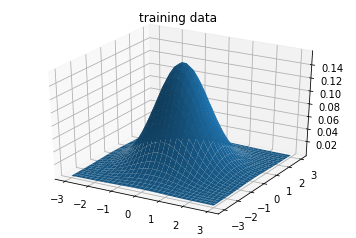

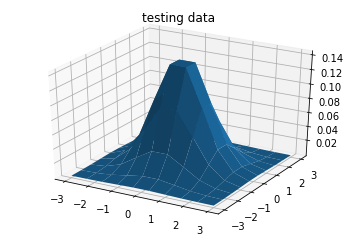

In [10]:
# training ------------------------------
A = 32j
x1, x2 = np.mgrid[-3.0:3.0:A, -3.0:3.0:A]
x1x2 = np.column_stack([x1.flat, x2.flat])

mu = np.array([0.0, 0.0])
covariance = np.diag([1, 1])

y = multivariate_normal.pdf(x1x2, mean=mu, cov=covariance)
y = y.reshape(x1.shape)

x_train = x1x2
y_train = y.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x1, x2, y)
plt.title('training data')
plt.show()

# testing -------------------------------
A = 10j

x1, x2 = np.mgrid[-3.0:3.0:A, -3.0:3.0:A]
x1x2 = np.column_stack([x1.flat, x2.flat])

mu = np.array([0.0, 0.0])
covariance = np.diag([1, 1])

y = multivariate_normal.pdf(x1x2, mean=mu, cov=covariance)
y = y.reshape(x1.shape)

x_test = x1x2
y_test = y.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x1, x2, y)
plt.title('testing data')
plt.show()

# (3) MLP

In [3]:
def gauss_mlp(B=16):
    # 2 input nodes
    inp = Input(shape=(2,), name='Input')

    # FC layers
    x = Dense(units=B, activation='sigmoid', name='fc')(inp)

    # Output
    gauss_out = Dense(units=1, activation='sigmoid', name='gauss_apxm')(x)

    # define model
    model = Model(inputs=inp, outputs=gauss_out, name='gauss_mlp')
    
    return model

# (4) training and evaluating MLP

### (4.1) Number of training samples (A) (no. of hidden nodes (B) = 16 and no. of epochs (C) = 100)

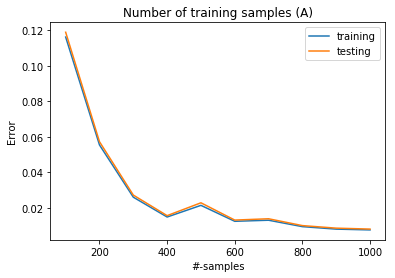

In [30]:
train_error = []
test_error = []
tot_train = 1001
A_array = []

B = 16
C = 100
for A in np.arange(100, tot_train, 100):
    # define the model
    model = gauss_mlp(B=B)

    # compile the model
    loss = 'mean_squared_error'
    lr = 0.01
    model.compile(loss=loss, optimizer=SGD(lr=lr))

    # train the model
    batch_size = 128
    epochs = C
    
    # items for training
    sel_indx = np.random.choice(range(1, tot_train), size=A, replace=False)
    model.fit(x_train[sel_indx], y_train[sel_indx],
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)

    train_error.append(model.evaluate(x_train, y_train, verbose=0))
    test_error.append(model.evaluate(x_test, y_test, verbose=0))
    A_array.append(A)
    
    # plot the relationship between A (training samples) and loss
    clear_output()
    plt.plot(A_array, train_error, label='training')
    plt.plot(A_array, test_error, label='testing')
    plt.legend()
    plt.title('Number of training samples (A)')
    plt.xlabel('#-samples')
    plt.ylabel('Error')
    plt.show()

### (4.2) Number of hidden nodes (B) (no. of training samples (A) = 800 and no. of epochs (C) = 100)

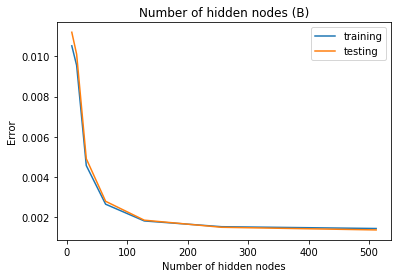

In [29]:
train_error = []
test_error = []
B_array = []
tot_train = 1001
    
A = 800
B = 8
C = 100
while B <= 512:
    # define the model
    model = gauss_mlp(B=B)

    # compile the model
    loss = 'mean_squared_error'
    lr = 0.01
    model.compile(loss=loss, optimizer=SGD(lr=lr))

    # train the model
    batch_size = 128
    epochs = C
    
    # items for training
    sel_indx = np.random.choice(range(1, tot_train), size=A, replace=False)
    model.fit(x_train[sel_indx], y_train[sel_indx],
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)

    train_error.append(model.evaluate(x_train, y_train, verbose=0))
    test_error.append(model.evaluate(x_test, y_test, verbose=0))
    B_array.append(B)
    
    # plot the relationship between B (hidden nodes) and loss
    clear_output()
    plt.plot(B_array, train_error, label='training')
    plt.plot(B_array, test_error, label='testing')
    plt.legend()
    plt.title('Number of hidden nodes (B)')
    plt.xlabel('Number of hidden nodes')
    plt.ylabel('Error')
    plt.show()
    
    B *= 2

### (4.3) Number of epochss (C) (no. of training samples (A) = 800 and no. of hidden nodes (B) = 128)

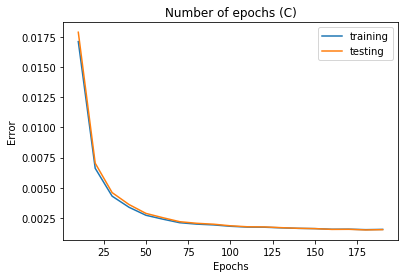

In [33]:
train_error = []
test_error = []
tot_train = 1001
C_array = []

A = 800
B = 128
for C in np.arange(10, 200, 10):
    # define the model
    model = gauss_mlp(B=B)

    # compile the model
    loss = 'mean_squared_error'
    lr = 0.01
    model.compile(loss=loss, optimizer=SGD(lr=lr))

    # train the model
    batch_size = 128
    epochs = C
    
    # items for training
    sel_indx = np.random.choice(range(1, tot_train), size=A, replace=False)
    model.fit(x_train[sel_indx], y_train[sel_indx],
                        validation_data=(x_test, y_test),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)

    train_error.append(model.evaluate(x_train, y_train, verbose=0))
    test_error.append(model.evaluate(x_test, y_test, verbose=0))
    C_array.append(C)
    
    # plot the relationship between C (epochs) and loss
    clear_output()
    plt.plot(C_array, train_error, label='training')
    plt.plot(C_array, test_error, label='testing')
    plt.legend()
    plt.title('Number of epochs (C)')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.show()